In [3]:
import warnings
warnings.filterwarnings("ignore")

from typing import Optional, List, Union
from numpy.typing import NDArray

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

from tsururu.strategies import StrategiesFactory
from tsururu.dataset import TSDataset

In [30]:
def get_results(
    cv: int,
    regime: str,
    y_true: Optional[List[NDArray[np.floating]]] = None,
    y_pred: Optional[List[NDArray[np.floating]]] = None,
    ids: Optional[List[Union[float, str]]] = None,
) -> pd.DataFrame:
    def _get_fold_value(
        value: Optional[Union[float, NDArray[np.floating]]], idx: int
    ) -> List[Optional[Union[float, NDArray[np.floating]]]]:
        if value is None:
            return [None]
        if isinstance(value[idx], float):
            return value[idx]
        if isinstance(value[idx], np.ndarray):
            return value[idx].reshape(-1)
        raise TypeError(f"Unexpected value type. Value: {value}")

    df_res_dict = {}

    for idx_fold in range(cv):
        # Fill df_res_dict
        for name, value in [("y_true", y_true), ("y_pred", y_pred)]:
            df_res_dict[f"{name}_{idx_fold+1}"] = _get_fold_value(
                value, idx_fold
            )
        if regime != "local":
            df_res_dict[f"id_{idx_fold+1}"] = _get_fold_value(ids, idx_fold)

    # Save datasets to specified directory
    df_res = pd.DataFrame(df_res_dict)
    return df_res

def plot_results(df, res, axes):
    for i, ax in enumerate(axes):
        df_slice = res.iloc[i * 96: (i + 1) * 96] 
        t = df[df['unique_id'] == i]['ds'].tail(296)
        ax.plot(t, df[df['unique_id'] == i]['y'].tail(296).reset_index(drop=True), label='y_true', c ='royalblue')
        ax.plot(t[200:296], df_slice['y_pred_1'], label='y_pred',c ='maroon') 
        mae = MAE(df[df['unique_id'] == i]['y'].tail(96), df_slice['y_pred_1'])
        mse = MSE(df[df['unique_id'] == i]['y'].tail(96), df_slice['y_pred_1'])
        ax.set_title(f'id {i}, MAE = {mae:.4f}, MSE = {mse:.4f}')
        ax.legend() 
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Value')
        ax.grid(True)
    plt.tight_layout()

## Using Autoformer

In [31]:
# for global and multivariate all time seires should be in one .csv file, divided by id 
# for local each time serie should be in its own .csv file also with id column 
df_path = "datasets/global/ettm1.csv"

# Configure the features settings
columns_and_features_params = {
    "target": {
        "column": ["y"],
        "type": "continious",
        
        "drop_raw_feature": False,
                },
    
    "date": {
        "column": ["ds"],
        "type": "datetime",
        
        "drop_raw_feature": False,
    },
    "id": {
        "column": ["unique_id"],
        "type": "categorical",
        "drop_raw_feature": False,
    }
}

# Configure the validation parameters
validation_params = None

# Configure the model parameters
model_params = {
    "h": 96,                    # int, forecast horizon
    "input_size": 96*7,           # int, maximum sequence length for truncated train backpropagation. Default -1 uses all history
    "hidden_size": 16,          # int=128, units of embeddings and encoders
    "conv_hidden_size": 16,     # int=32, channels of the convolutional encoder
    "learning_rate": 1e-3,      
    "max_steps": 10,             # int=1000, maximum number of training steps
    # "freq": "T"       # date frequency str aka 'D', 'M' or int 7, 30
}

# Configure the strategies parameters
strategy_params = {
    "is_multivariate": True,  
    "strategy_name": "MIMOStrategy",
    "strategy_params": {
        "horizon": 96,
        "model_name": "AutoformerRegressor_NN",
        "model_params": model_params,
        "validation_params": validation_params,
    }
}

In [32]:
strategies_factory = StrategiesFactory()
df=pd.read_csv(df_path,sep=',')
dataset = TSDataset(
    data=df,
    columns_and_features_params=columns_and_features_params,
    history=96*7
)

In [33]:
strategy = strategies_factory[strategy_params]

In [34]:
ids, test, pred, fit_time, forecast_time, num_iterations = strategy.back_test(dataset, cv=1)

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

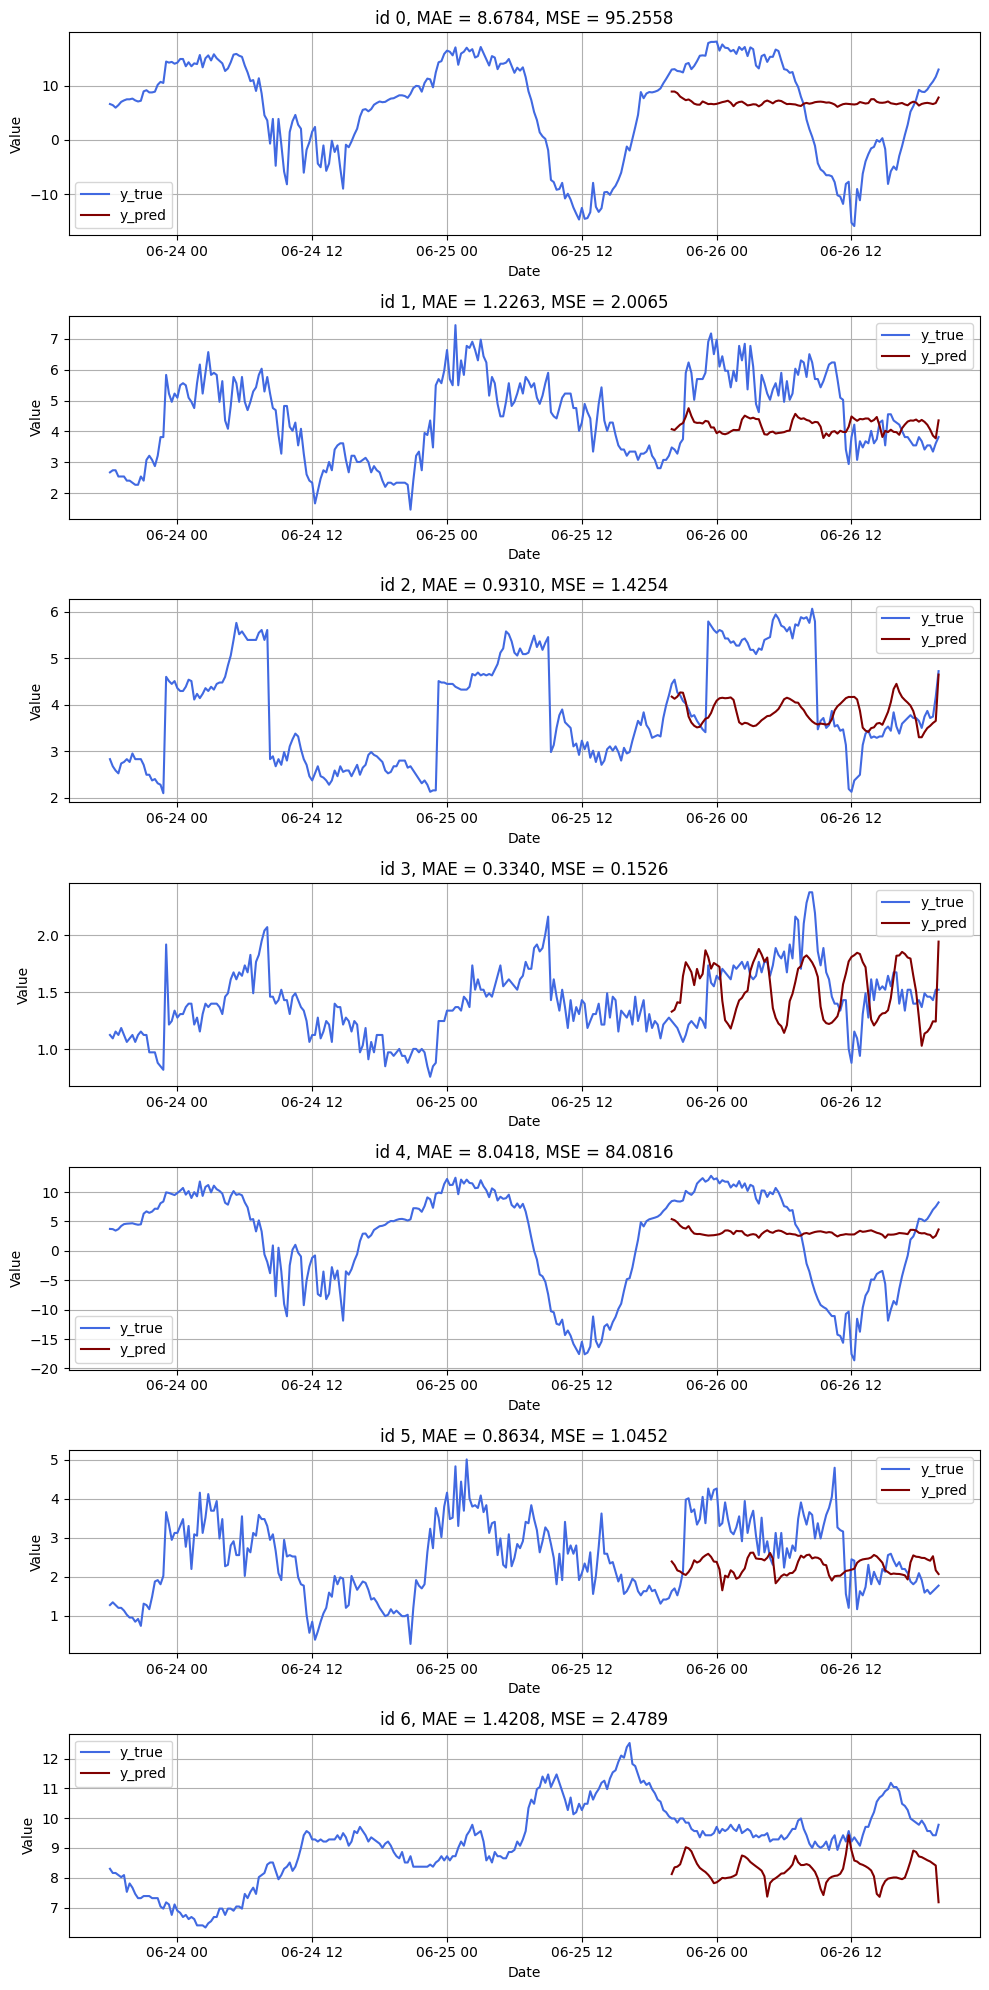

In [35]:
res1 = get_results(cv=1, regime="local", y_true=test, y_pred=pred, ids=ids)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20))
plot_results(df, res1, axes)

## Using PatchTST

In [40]:
# Configure the model parameters
model_params = {
    "h": 96,
    "input_size": 96*7,
    "hidden_size": 32,
    "patch_len": 64,
    "n_heads":4,
    "learning_rate": 1e-3,
    "max_steps": 10,
    # "freq": "T"       # date frequency str aka 'D', 'M' or int 7, 30
}

# Configure the strategies parameters
strategy_params = {
    "is_multivariate": True,  
    "strategy_name": "MIMOStrategy",
    "strategy_params": {
        "horizon": 96,
        "model_name": "PatchTSTRegressor_NN",
        "model_params": model_params,
        "validation_params": validation_params,
    }
}

In [41]:
strategy = strategies_factory[strategy_params]

In [42]:
ids, test, pred, fit_time, forecast_time, num_iterations = strategy.back_test(dataset, cv=1)

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

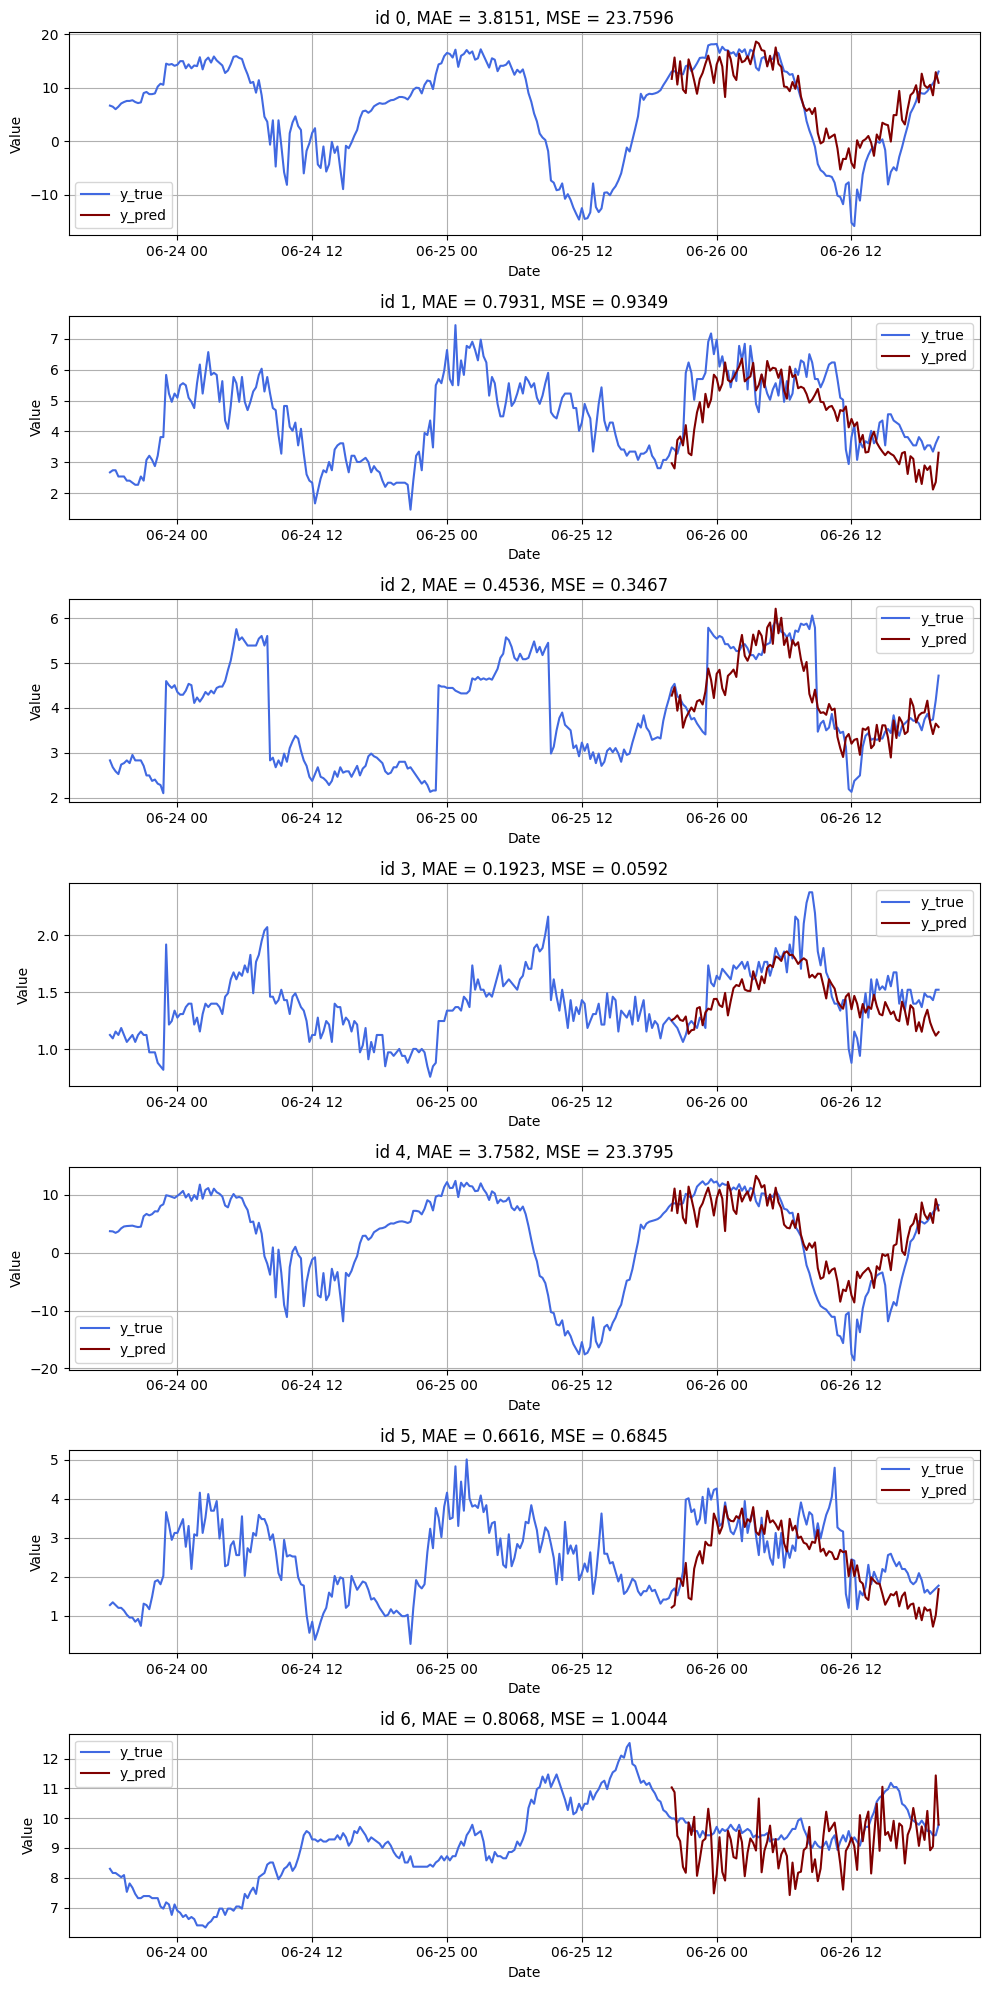

In [43]:
res2 = get_results(cv=1, regime="local", y_true=test, y_pred=pred, ids=ids)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20))
plot_results(df, res2, axes)

## Using Informer

In [44]:
# Configure the model parameters
model_params = {
    "h": 96,                    # int, forecast horizon
    "input_size": 96*7,         # int, maximum sequence length for truncated train backpropagation. Default -1 uses all history
    "hidden_size": 32,          # int=128, units of embeddings and encoders
    "conv_hidden_size": 32,     # int=32, channels of the convolutional encoder
    "learning_rate": 1e-3,     
    "max_steps": 15,             # int=1000, maximum number of training steps
    # "freq": "D"       # date frequency str aka 'D', 'M' or int 7, 30
}

# Configure the strategies parameters
strategy_params = {
    "is_multivariate": True,  
    "strategy_name": "MIMOStrategy",
    "strategy_params": {
        "horizon": 96,
        "model_name": "InformerRegressor_NN",
        "model_params": model_params,
        "validation_params": validation_params,
    }
}

In [45]:
strategy = strategies_factory[strategy_params]

In [46]:
ids, test, pred, fit_time, forecast_time, num_iterations = strategy.back_test(dataset, cv=1)

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

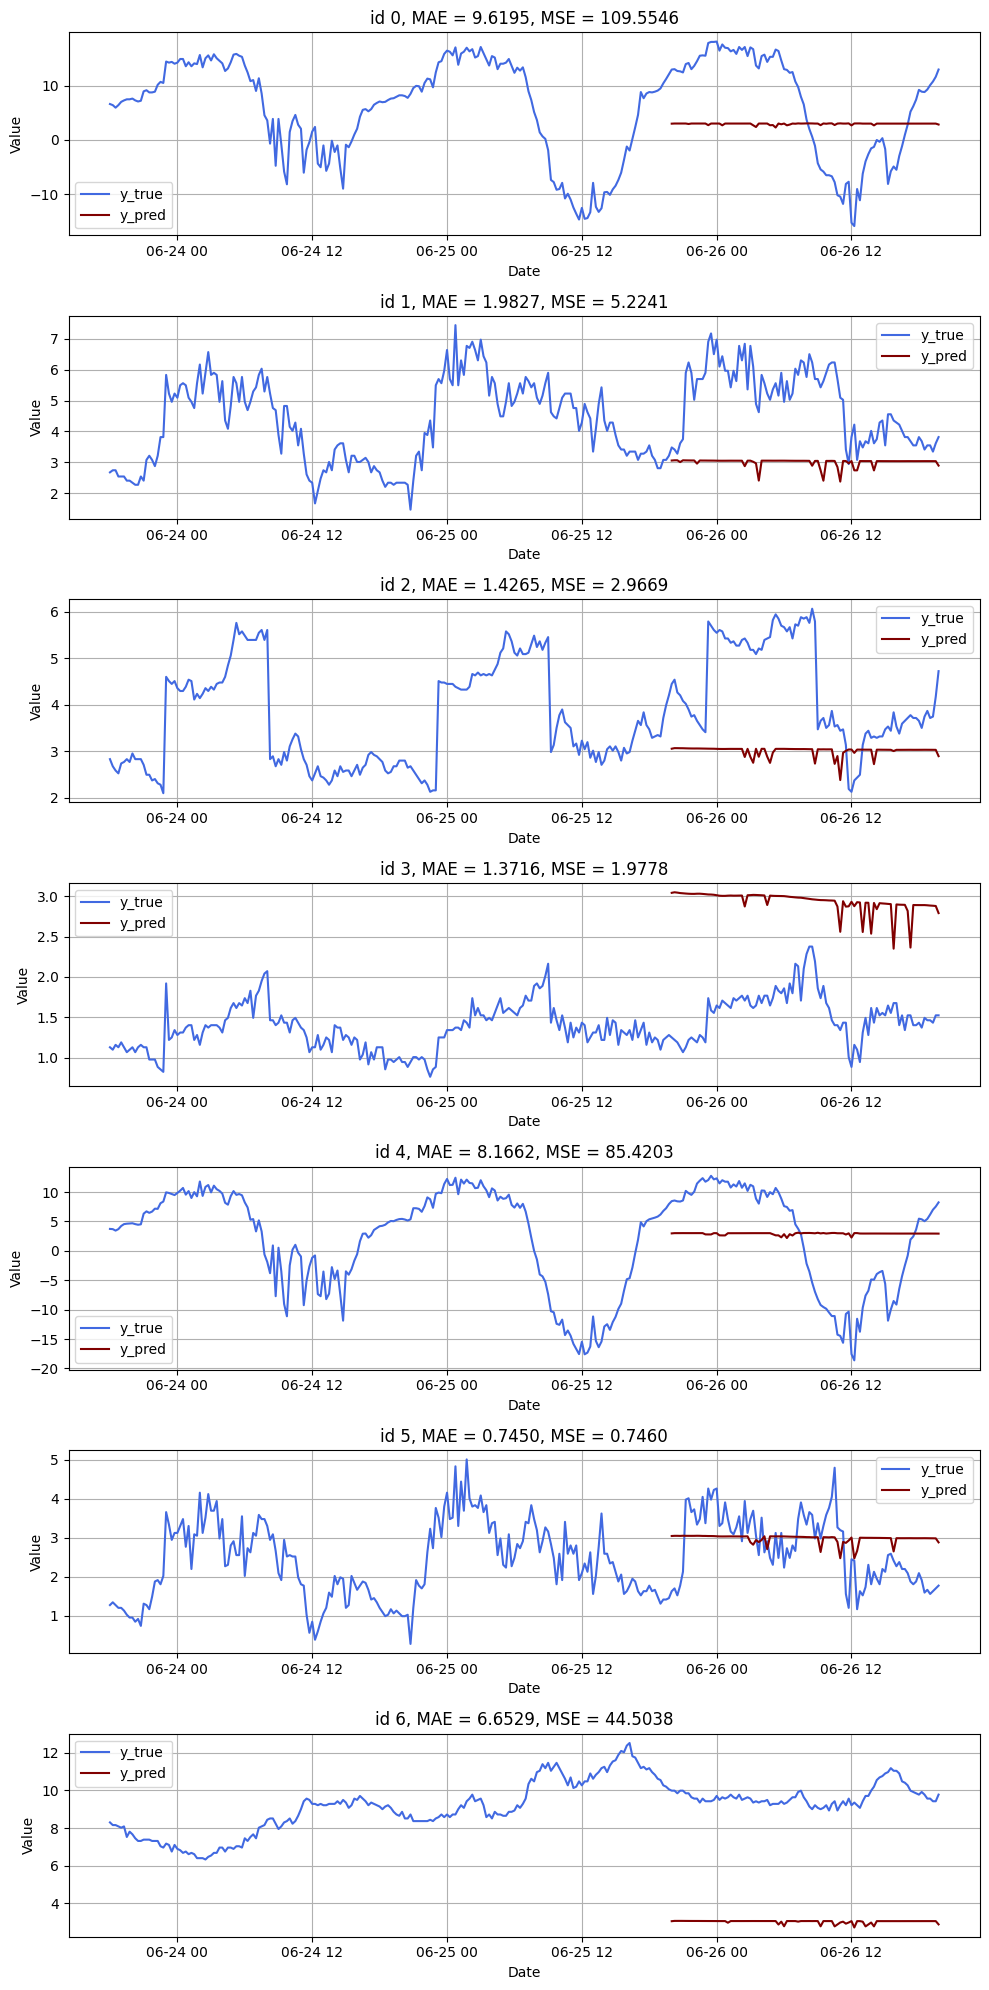

In [47]:
res3 = get_results(cv=1, regime="local", y_true=test, y_pred=pred, ids=ids)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20))
plot_results(df, res3, axes)